This notebook contains code and results for a CNN model for 5-class emotion classification.<br />
Run the notebook from scripts directory

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
import urllib.request
import zipfile

from keras.callbacks import EarlyStopping
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
num_classes = 5

# Number of dimensions for word embeddings.
embed_num_dims = 300

Explore data length for amazon to determine appropriate input length.

In [3]:
amazon = pd.read_csv('../data/preprocessed/amazon.csv')

In [4]:
amazon['length'] = amazon['REVIEW_TEXT'].apply(lambda x: len(x.split()))

<AxesSubplot:>

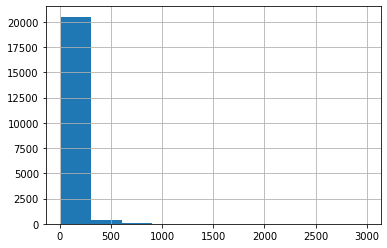

In [5]:
amazon.length.hist()

In [6]:
len(amazon.loc[amazon['length'] > 500])/len(amazon)

0.007294745875846286

Since less than 1% of reviews is >500 words long, use 500 as max sequence length.

In [7]:
max_seq_len = 500

In [8]:
# Define emotion classes
emotions = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [9]:
data_train = pd.read_csv('../data/training_data/data_train_5_classes.csv')
data_test = pd.read_csv('../data/training_data/data_test_5_classes.csv')

In [63]:
# Split training data into training and validation sets.
X_train, X_dev, y_train, y_dev = train_test_split(data_train.Text, data_train.Emotion,
                                                  shuffle=True,
                                                  stratify=data_train.Emotion, 
                                                  test_size=0.1)

In [64]:
X_test = data_test.Text
y_test = data_test.Emotion

In [65]:
def clean_text(text):
    """Clean text and tokenise.""" 
    text = text.lower()
    
    # Remove common contractions.
    text = re.sub(r"can't", 'cannot', text)
    text = re.sub(r"\'s",' ', text)
    text = re.sub(r"\'ve", ' have ', text)
    text = re.sub(r"n't", ' not ', text)
    text = re.sub(r"im", 'i am ', text)
    text = re.sub(r"i'm", 'i am ', text)
    text = re.sub(r"\'re", ' are ', text)
    text = re.sub(r"\'ll", ' will ', text)
    
    # Remove hashtags and tags.
    text = re.sub(r"(#[\d\w\.]+)", '', text)
    text = re.sub(r"(@[\d\w\.]+)", '', text)    
                
    # Remove operations and process punctuation.           
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
  
    # Remove remaining punctuation and missed symbols.
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    text = word_tokenize(text)
    return ' '.join(text)

In [66]:
data = data_train.append(data_test, ignore_index=True)
texts = [clean_text(text) for text in data.Text]

texts_train = [clean_text(text) for text in X_train]
texts_dev = [clean_text(text) for text in X_dev]
texts_test = [clean_text(text) for text in X_test]

In [67]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

seq_train = tokenizer.texts_to_sequences(texts_train)
seq_dev = tokenizer.texts_to_sequences(texts_dev)
seq_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# Reserve 1 for padding.
vocab_size = len(index_of_words) + 1

In [68]:
X_train_pad = pad_sequences(seq_train, maxlen = max_seq_len)
X_dev_pad = pad_sequences(seq_dev, maxlen = max_seq_len)
X_test_pad = pad_sequences(seq_test, maxlen = max_seq_len)

In [69]:
# Assign integer labels to y values.
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

y_train = [encoding[x] for x in y_train]
y_dev = [encoding[x] for x in y_dev]
y_test = [encoding[x] for x in y_test]

In [70]:
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [71]:
def create_embedding_matrix(filepath, word_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [19]:
fname = 'embeddings/wiki-news-300d-1M.vec'
if not os.path.isfile(fname):
    print('Geting word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('Done.')
    os.remove('wiki-news-300d-1M.vec.zip')

Geting word vectors...
Done.


In [72]:
embedding_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims, vocab_size)

In [37]:
# The following hyperparameters have been tried before settling on the best ones.
# A model has been created for each set and performances compared, code is omitted for clarity.
kernel_sizes = [3, 5]
filters = [64, 128, 256]
learning_rates = [0.01, 0.001, 0.0001]
max_seq_length = [300, 500]

In [73]:
# Define final model.
kernel_size = 3
filters = 128

embedding_layer = Embedding(vocab_size,
                            embed_num_dims,
                            input_length = max_seq_len,
                            weights = [embedding_matrix],
                            trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          3603300   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 498, 128)          115328    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 3,752,937
Trainable params: 149,637
Non-trainable params: 3,603,300
_________________________________________________________________


In [74]:
batch_size = 64
max_epochs = 50
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(X_train_pad, y_train, 
                    batch_size=batch_size,
                    epochs=max_epochs,
                    validation_data=(X_dev_pad, y_dev),
                    callbacks=[early_stopping_monitor])

Epoch 1/50
112/112 [==============================] - 12s 100ms/step - loss: 1.5752 - accuracy: 0.2622 - val_loss: 1.5064 - val_accuracy: 0.4156
Epoch 2/50
112/112 [==============================] - 11s 98ms/step - loss: 1.4619 - accuracy: 0.4688 - val_loss: 1.3714 - val_accuracy: 0.4811
Epoch 3/50
112/112 [==============================] - 11s 97ms/step - loss: 1.3169 - accuracy: 0.5426 - val_loss: 1.2304 - val_accuracy: 0.5630
Epoch 4/50
112/112 [==============================] - 11s 97ms/step - loss: 1.1463 - accuracy: 0.6484 - val_loss: 1.0920 - val_accuracy: 0.6259
Epoch 5/50
112/112 [==============================] - 11s 96ms/step - loss: 0.9980 - accuracy: 0.6915 - val_loss: 0.9619 - val_accuracy: 0.6599
Epoch 6/50
112/112 [==============================] - 15s 130ms/step - loss: 0.8565 - accuracy: 0.7345 - val_loss: 0.8739 - val_accuracy: 0.7040
Epoch 7/50
112/112 [==============================] - 13s 113ms/step - loss: 0.7552 - accuracy: 0.7552 - val_loss: 0.8230 - val_accura

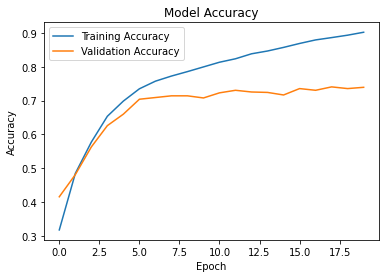

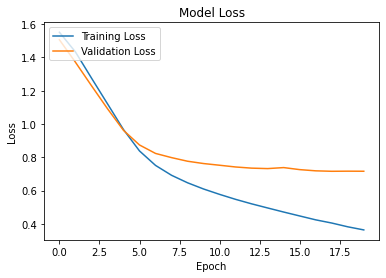

In [75]:
# Plot loss and accuracy.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [86]:
# See test set results.
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [emotions[pred] for pred in predictions]

In [25]:
model.save('../trained_models/cnn_w2v.h5')

In [87]:
print('CNN 5 classes classification report: ') 
print(classification_report(data_test.Emotion, predictions, digits=4))

CNN 5 classes classification report: 
              precision    recall  f1-score   support

       anger     0.6650    0.7504    0.7051       693
        fear     0.7880    0.7334    0.7597       679
         joy     0.7758    0.7440    0.7596       707
     neutral     0.7511    0.7994    0.7745       638
     sadness     0.7717    0.7101    0.7396       676

    accuracy                         0.7468      3393
   macro avg     0.7503    0.7474    0.7477      3393
weighted avg     0.7501    0.7468    0.7473      3393



Text(0.5, 1.0, 'CNN 5 classes confusion matrix')

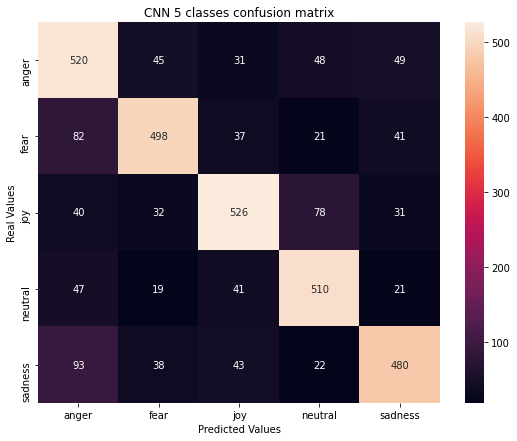

In [78]:
# Get confusion matrix.
df_cm = pd.DataFrame(confusion_matrix(data_test.Emotion, predictions), index = [i for i in ['anger', 'fear', 'joy', 'neutral', 'sadness']],
                  columns = [i for i in ['anger', 'fear', 'joy', 'neutral', 'sadness']])
plt.figure(figsize = (9,7))
hm = sn.heatmap(df_cm, annot=True, fmt='g')
hm.set_xlabel('Predicted Values')
hm.set_ylabel('Real Values')
hm.set_title('CNN 5 classes confusion matrix')

Now, obtain predictions on amazon dataset.

In [55]:
amazon = pd.read_csv('../data/preprocessed/amazon.csv')

In [56]:
amazon

,REVIEW_TEXT,VERACITY
0,"When least you think so, this product will sav...",Fake
1,Lithium batteries are something new introduced...,Fake
2,I purchased this swing for my baby. She is 6 m...,Fake
3,I was looking for an inexpensive desk calcolat...,Fake
4,I only use it twice a week and the results are...,Fake
...,...,...
20969,"I bought these for work. I have high arches, ...",Real
20970,Crocs are one of only two brands of shoes that...,Real
20971,I love moccasins This fit like it was custom ...,Real
20972,I wish these were a little more durable. I got...,Real


In [79]:
amazon_text = amazon.REVIEW_TEXT
amazon_texts = [clean_text(text) for text in amazon_text]
seq_amazon = tokenizer.texts_to_sequences(amazon_texts)
amazon_text_pad = pad_sequences(seq_amazon, maxlen = max_seq_len)

In [80]:
for emotion in emotions:
    amazon[emotion] = 0
amazon['PREDICTION'] = 0

In [81]:
predictions_amazon = model.predict(amazon_text_pad)

In [82]:
for i in range(len(amazon['REVIEW_TEXT'])):
    if i%1000 == 0:
        print('processing', i, ' of', len(amazon))
    j = 0
    for j, emotion in enumerate(emotions):
        amazon.iloc[i, amazon.columns.get_loc(emotion)] = predictions_amazon[i][j]
    predictions = np.argmax(predictions_amazon[i])
    predictions = emotions[predictions]
    amazon.iloc[i, amazon.columns.get_loc('PREDICTION')] = predictions

processing 0  of 20974
processing 1000  of 20974
processing 2000  of 20974
processing 3000  of 20974
processing 4000  of 20974
processing 5000  of 20974
processing 6000  of 20974
processing 7000  of 20974
processing 8000  of 20974
processing 9000  of 20974
processing 10000  of 20974
processing 11000  of 20974
processing 12000  of 20974
processing 13000  of 20974
processing 14000  of 20974
processing 15000  of 20974
processing 16000  of 20974
processing 17000  of 20974
processing 18000  of 20974
processing 19000  of 20974
processing 20000  of 20974


In [83]:
amazon

,REVIEW_TEXT,VERACITY,joy,fear,anger,sadness,neutral,PREDICTION
0,"When least you think so, this product will sav...",Fake,0.059971,0.038312,0.219190,0.028211,0.654315,neutral
1,Lithium batteries are something new introduced...,Fake,0.042664,0.104629,0.758266,0.060904,0.033536,anger
2,I purchased this swing for my baby. She is 6 m...,Fake,0.230921,0.130540,0.158822,0.117755,0.361962,neutral
3,I was looking for an inexpensive desk calcolat...,Fake,0.059857,0.497896,0.200699,0.081105,0.160443,fear
4,I only use it twice a week and the results are...,Fake,0.369998,0.238711,0.203988,0.066481,0.120823,joy
...,...,...,...,...,...,...,...,...
20969,"I bought these for work. I have high arches, ...",Real,0.133580,0.057402,0.251957,0.091467,0.465593,neutral
20970,Crocs are one of only two brands of shoes that...,Real,0.487293,0.088118,0.206472,0.060743,0.157374,joy
20971,I love moccasins This fit like it was custom ...,Real,0.282923,0.291710,0.224478,0.050961,0.149929,fear
20972,I wish these were a little more durable. I got...,Real,0.125975,0.466806,0.229611,0.069143,0.108465,fear


<AxesSubplot:title={'center':'CNN 5 classes predictions'}>

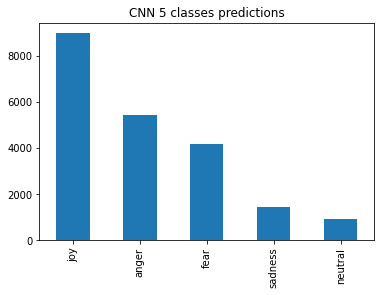

In [84]:
amazon.PREDICTION.value_counts().plot(kind='bar', title='CNN 5 classes predictions')

In [85]:
amazon.to_csv('../data/results/amazon_cnn5.csv', index=False)